In [1]:
%config InlineBackend.figure_format = "svg"

# Temporal train test split
from sktime.forecasting.model_selection import temporal_train_test_split

# Imports for time-series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf

# Imports for fequency domain analysis
from scipy.signal import periodogram
from scipy.stats import entropy

# Imports for data acquisition, manipulation and plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Importing data

In [2]:
datapath = "data/daily_weather_data.csv"
df = pd.read_csv(datapath)
df

,date,country,city,Latitude,Longitude,tavg,tmin,tmax,wdir,wspd,pres
0,21-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.4,20.9,25.5,329.0,9.3,1009.6
1,22-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.0,25.7,337.0,9.4,1010.0
2,23-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.1,25.5,41.0,8.2,1007.7
3,24-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,24.3,20.8,27.1,10.0,9.3,1004.4
4,25-07-2018,Abkhazia,Sukhumi,43.001525,41.023415,26.5,22.7,30.0,9.0,9.7,1002.0
...,...,...,...,...,...,...,...,...,...,...,...
324642,07-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,22.1,18.6,25.6,3.0,24.7,1013.7
324643,08-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,22.1,19.6,25.6,2.0,20.5,1013.0
324644,09-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,23.4,19.6,29.6,34.0,24.0,1015.4
324645,10-10-2022,Western Sahara,El Aaiún,27.125287,-13.162500,23.1,18.6,29.7,39.0,28.4,1017.6


In [3]:
df.dtypes

date          object
country       object
city          object
Latitude     float64
Longitude    float64
tavg         float64
tmin         float64
tmax         float64
wdir         float64
wspd         float64
pres         float64
dtype: object

As we can see from the dtypes of the dataframe columns, the date column is not yet recognized as a date, but is rather an object type.
We will first convert this data into the correct datetime format.

Although there are way too many datapoints for us to check every possible datetime format, it seems that at least most of them follow the %d-%m-%Y format. Let's check if all of them are indeed in this format by verifying if pandas throws an error:

In [4]:
pd.to_datetime(df["date"], format="%d-%m-%Y")

0        2018-07-21
1        2018-07-22
2        2018-07-23
3        2018-07-24
4        2018-07-25
            ...    
324642   2022-10-07
324643   2022-10-08
324644   2022-10-09
324645   2022-10-10
324646   2022-10-11
Name: date, Length: 324647, dtype: datetime64[ns]

Pandas successfully converted all datapoints using this format! We are safe to use this format to convert the date column into a date format. While we're at it, we'll also convert the date column to the dataframe index:

In [5]:
# Create datetime date column
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")
df = df.set_index("date")
df

,country,city,Latitude,Longitude,tavg,tmin,tmax,wdir,wspd,pres
date,,,,,,,,,,
2018-07-21,Abkhazia,Sukhumi,43.001525,41.023415,23.4,20.9,25.5,329.0,9.3,1009.6
2018-07-22,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.0,25.7,337.0,9.4,1010.0
2018-07-23,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.1,25.5,41.0,8.2,1007.7
2018-07-24,Abkhazia,Sukhumi,43.001525,41.023415,24.3,20.8,27.1,10.0,9.3,1004.4
2018-07-25,Abkhazia,Sukhumi,43.001525,41.023415,26.5,22.7,30.0,9.0,9.7,1002.0
...,...,...,...,...,...,...,...,...,...,...
2022-10-07,Western Sahara,El Aaiún,27.125287,-13.162500,22.1,18.6,25.6,3.0,24.7,1013.7
2022-10-08,Western Sahara,El Aaiún,27.125287,-13.162500,22.1,19.6,25.6,2.0,20.5,1013.0
2022-10-09,Western Sahara,El Aaiún,27.125287,-13.162500,23.4,19.6,29.6,34.0,24.0,1015.4


## Understanding the data

Let's take another look at the data columns and try to understand it better:

In [6]:
df.head()

,country,city,Latitude,Longitude,tavg,tmin,tmax,wdir,wspd,pres
date,,,,,,,,,,
2018-07-21,Abkhazia,Sukhumi,43.001525,41.023415,23.4,20.9,25.5,329.0,9.3,1009.6
2018-07-22,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.0,25.7,337.0,9.4,1010.0
2018-07-23,Abkhazia,Sukhumi,43.001525,41.023415,23.5,21.1,25.5,41.0,8.2,1007.7
2018-07-24,Abkhazia,Sukhumi,43.001525,41.023415,24.3,20.8,27.1,10.0,9.3,1004.4
2018-07-25,Abkhazia,Sukhumi,43.001525,41.023415,26.5,22.7,30.0,9.0,9.7,1002.0


The dataframe has the following columns:
- Country: the country of the weather data
- City: the city of the weather data
- Latitude: the latitude of the city
- Longitude: the longitude of the city
- tavg: average temperature for that city in that day (in Celsius)
- tmin: minimum temperature for that city in that day (in Celsius)
- tmax: maximum temperature for that city in that day (in Celsius)
- wdir: average wind direction for that city in that day (in degrees)
- wspd: average wind speed for that city in that day (in km/h)
- pres: average sea-level pressure for that city in that day (in hPa)

As we can see, there are two different kinds of features:
- Predictor variables: country, city, latitude and longitude, which describe the city of the weather forecast
- Time-series variables: tavg, tmin, tmax, wdir, wspd and pres, which describe the weather forecast of the city described by the predictor variables

In this notebook, we will be working only with time-series models. These are models that do not take into account predictor variables, only time-series variables. If $y_t$ is the true value of a predictor variable at time $t$, and $\hat{y}_t$ its estimated value, these models are of the form:

$$ \hat{y}_t = f \left( y_1, \dots, y_{t-1} \right) $$

It would be possible to train these models one every one of the cities of the dataset, but it is likely that it would be bad at predicting the temperature of other cities, since they don't take predictor variables into account.

## Filtering the dataset

Let's quickly check how many countries and cities there are in this dataset:

In [7]:
df["city"].unique().shape

(192,)

In [8]:
df["country"].unique().shape

(194,)

We can easily see that there are a total of 192 cities and 194 countries. One would expect there to be more cities than countries, but this is likely due to formatting errors in the city and/or country names, as well as possible missing values in these columns.

Since we will be working with time-series models that do not accept feature variables, we will shift our focus to only one of the cities:

In [9]:
df["city"].unique()

array(['Sukhumi', 'Mariehamn', 'Tirana', 'Algiers', 'Pago Pago', 'Luanda',
       'The Valley', "St. John's", 'Buenos Aires', 'Oranjestad', 'Vienna',
       'Baku', 'Nassau', 'Manama', 'Dhaka', 'Bridgetown', 'Minsk',
       'Brussels', 'Porto-Novo', 'Hamilton', 'Bouvet Island', 'Road Town',
       'Bandar Seri Begawan', 'Ouagadougou', 'Phnom Penh', 'Ottawa',
       'Praia', 'George Town', 'Bangui', "N'Djamena", 'Beijing',
       'Flying Fish Cove', 'West Island', 'Moroni', 'Kinshasa',
       'Brazzaville', 'Avarua', 'Yamoussoukro', 'Zagreb ', 'Havana',
       'Willemstad', 'Nicosia', 'Prague', 'Copenhagen', 'Djibouti',
       'Roseau', 'Santo Domingo', 'Cairo', 'San Salvador', 'Malabo',
       'Tallinn', 'Stanley', 'Tórshavn', 'Suva', 'Helsinki', 'Paris',
       'Cayenne', 'Papeete', 'Saint-Pierre ', 'Libreville', 'Banjul',
       'Berlin', 'Accra', 'Gibraltar', 'Athens', 'Nuuk', "St. George's",
       'Basse-Terre', 'Hagåtña', 'St. Peter Port', 'Conakry', 'Bissau',
       'Georgetown'

In [10]:
df = df.query("city == 'Budapest'")
df

,country,city,Latitude,Longitude,tavg,tmin,tmax,wdir,wspd,pres
date,,,,,,,,,,
2018-01-01,Hungary,Budapest,47.497912,19.040235,3.1,0.6,5.4,48.0,6.5,1011.7
2018-01-02,Hungary,Budapest,47.497912,19.040235,5.0,2.3,7.7,335.0,11.4,1009.5
2018-01-03,Hungary,Budapest,47.497912,19.040235,4.0,0.7,6.6,223.0,12.2,1007.9
2018-01-04,Hungary,Budapest,47.497912,19.040235,4.7,2.2,10.4,190.0,8.0,1005.8
2018-01-05,Hungary,Budapest,47.497912,19.040235,6.4,3.7,9.5,144.0,6.3,1007.3
...,...,...,...,...,...,...,...,...,...,...
2022-10-07,Hungary,Budapest,47.497912,19.040235,15.6,11.0,21.4,69.0,6.5,1028.0
2022-10-08,Hungary,Budapest,47.497912,19.040235,14.6,9.7,20.0,59.0,5.1,1021.7
2022-10-09,Hungary,Budapest,47.497912,19.040235,15.4,11.4,19.6,6.0,8.2,1023.5


Since we have fixed a city to analyze and forecast the weather, we can drop the country, city, Latitude and Longitude variables, as they hold no valuable information:

In [11]:
df = df.drop(columns=["country", "city", "Latitude", "Longitude"])
df

,tavg,tmin,tmax,wdir,wspd,pres
date,,,,,,
2018-01-01,3.1,0.6,5.4,48.0,6.5,1011.7
2018-01-02,5.0,2.3,7.7,335.0,11.4,1009.5
2018-01-03,4.0,0.7,6.6,223.0,12.2,1007.9
2018-01-04,4.7,2.2,10.4,190.0,8.0,1005.8
2018-01-05,6.4,3.7,9.5,144.0,6.3,1007.3
...,...,...,...,...,...,...
2022-10-07,15.6,11.0,21.4,69.0,6.5,1028.0
2022-10-08,14.6,9.7,20.0,59.0,5.1,1021.7
2022-10-09,15.4,11.4,19.6,6.0,8.2,1023.5


Now let's check if there are any missing dates in our date column:

In [12]:
pd.date_range(start="2018-01-01", end="2022-10-11", freq="D").difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Seems like there aren't! Let's split the dataset intro train and test sets:

In [13]:
# Get training and testing dataframes
df_train, df_test = temporal_train_test_split(df, test_size=14)

# Save these dataframes
df_train.to_csv("data/train.csv")
df_test.to_csv("data/test.csv")

## Data cleaning

Let's look for missing values in our columns:

In [14]:
df.isna().sum()

tavg     2
tmin     5
tmax     3
wdir    23
wspd    23
pres     8
dtype: int64

It seems that there are a few missing values in the numeric columns. We will fix them by using linear interpolation:

In [15]:
df = df.interpolate(method="linear")
df.isna().sum()

tavg    0
tmin    0
tmax    0
wdir    0
wspd    0
pres    0
dtype: int64

## Time plots

Firstly to facilitate making the time plots, let's create some columns to represent days, months and years of the date index:

In [16]:
# Save current numeric features
num_features = df.columns

# Create new date features
df["day"] = df.index.day
df["week"] = df.index.week
df["month"] = df.index.month
df["year"] = df.index.year
df["year"]

/tmp/ipykernel_54733/2817128643.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df.index.week


date
2018-01-01    2018
2018-01-02    2018
2018-01-03    2018
2018-01-04    2018
2018-01-05    2018
              ... 
2022-10-07    2022
2022-10-08    2022
2022-10-09    2022
2022-10-10    2022
2022-10-11    2022
Name: year, Length: 1745, dtype: int64

The first analysis we will make is to plot the different numeric columns over time:

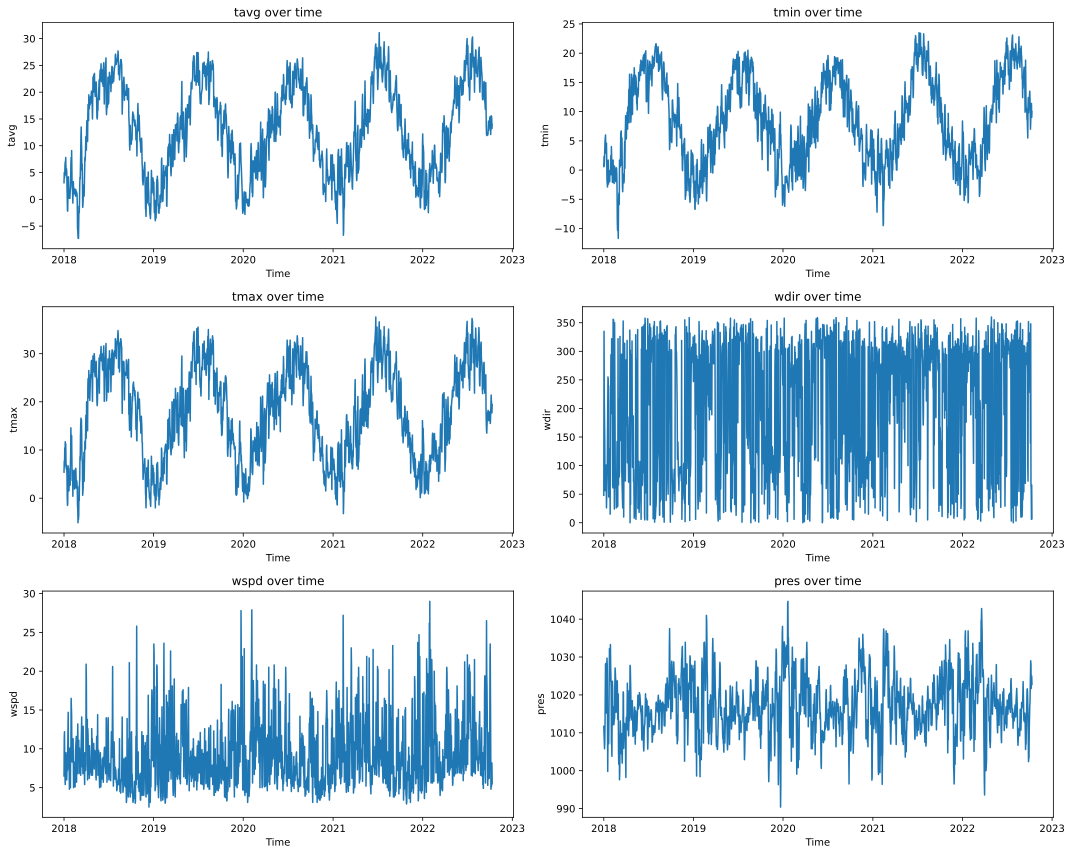

In [17]:
# Create subplot
rows, cols = 3, 2
fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

# Iterate every numeric features
for k, col in enumerate(num_features):
    
    # Get right axis
    i, j = k // cols, k % cols
    ax = axs[i,j]
    
    # Get x and y
    x = df.index
    y = df[col]
    
    # Plot the column
    ax.set_title(f"{col} over time")
    ax.plot(x, y)
    ax.set_xlabel("Time")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

From these plots alone, we can get many useful insights:
- All temperature features (avg, min and max) have a very strong yearly seasonal component.
- Pressure seems to have a somewhat seasonal component, although it seems from the plot above that it is mostly a noisy signal.
- Both wind speed and wind direction seem mostly noisy and unpredictable, although wind speed does also seem to have a very weak seasonal component.

To be able to inspect every season individually and see the more finegrained variations of these variables, let's make seasonal plots for them:

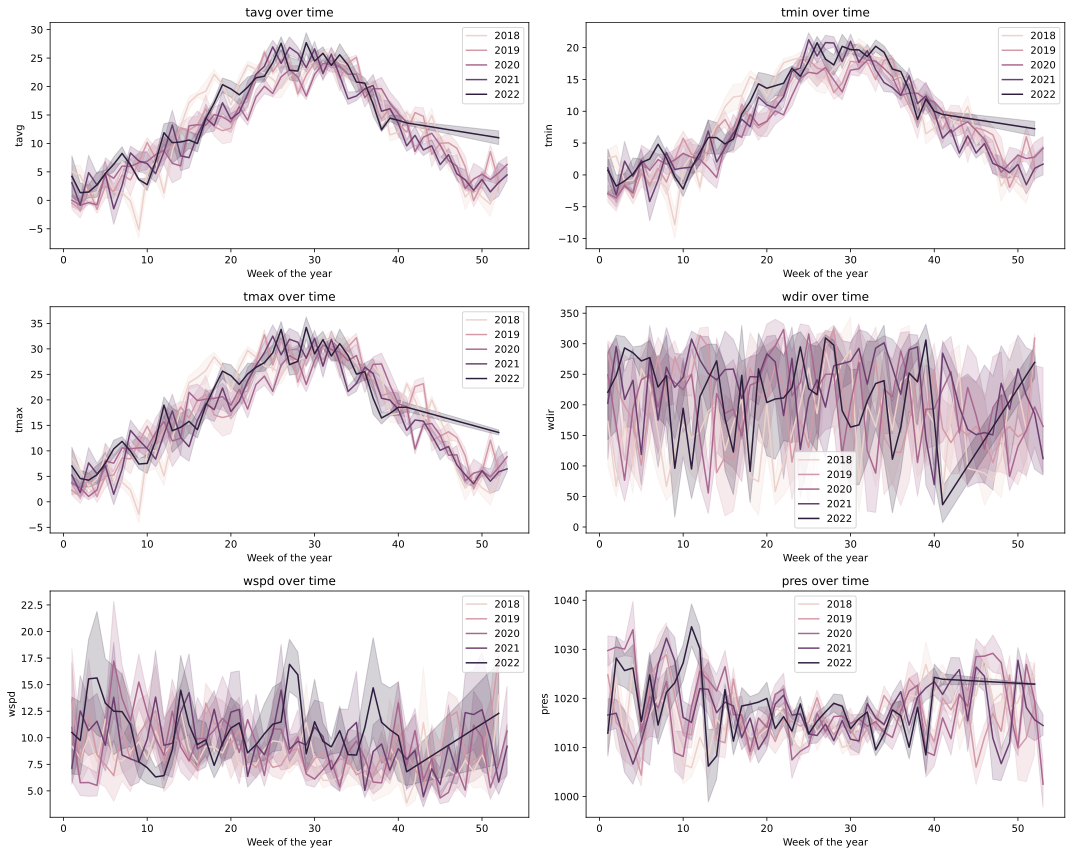

In [18]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

# Iterate numeric columns
for k, col in enumerate(num_features):
    
    # Get axis to plot on
    i, j = k // cols, k % cols
    ax = axs[i,j]
    
    # Configure axis
    ax.set_title(f"{col} over time")
    ax.set_xlabel("Week of the year")
    ax.set_ylabel(col)
    
    # Make seasonal plot
    sns.lineplot(x="week", y=col, hue="year", data=df, ax=ax)
        
    ax.legend()
    
plt.tight_layout()
plt.show()

On this closer inspection, none of these numeric features seems to display any more predictable behaviour in smaller time scales. In fact, in this closer look, it does seem that wind speed, wind direction and pressure are very unpredictable as their signals seem like mostly noise.

To better check if there is any hidden seasonality in these time-series, we will look at their representation in the frequency domain. For any signal $y(t)$, this can be done by calculating $\mathcal{F}(y(t))(w)$, its Fourier transform. The Fourier transform can be used to calculate another quantity, the Power spectral density $\left| \mathcal{F}(y) \right|^2$, which represents how much of each frequency is present in the original signal $y$.

Let's plot the Power spectral density for all of the time-series above:

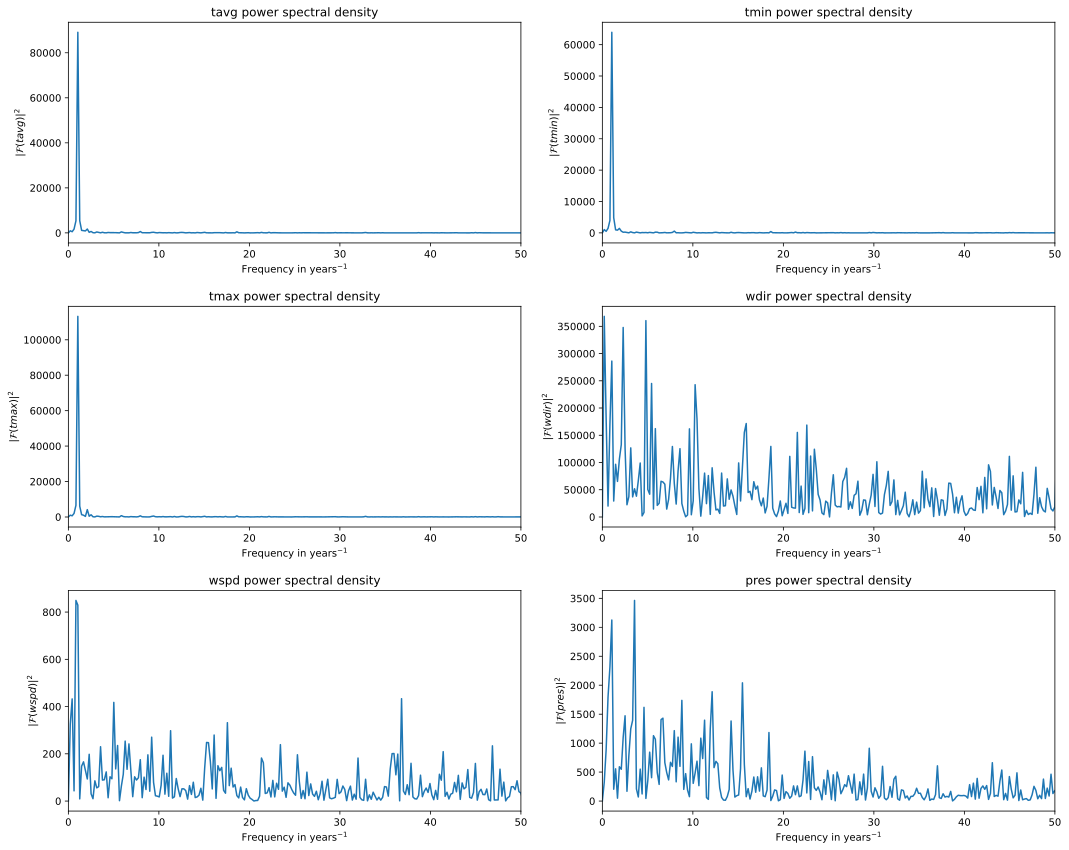

In [19]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

# Iterate numeric columns
for k, col in enumerate(num_features):
    
    # Get axis to plot on
    i, j = k // cols, k % cols
    ax = axs[i,j]
    
    # Configure axis
    ax.set_title(f"{col} power spectral density")
    ax.set_xlabel("Frequency in years$^{-1}$")
    ax.set_ylabel(f"$|\mathcal{{F}}({col})|^2$")
    
    # Calculate power spectral density
    f, p = periodogram(df[col].values)
    
    # Convert frequency from days to years
    f *= 365
    
    # Make seasonal plot
    sns.lineplot(x=f, y=p, ax=ax)
    ax.set_xlim(left=0, right=50)
    
plt.tight_layout()
plt.show()

From these PSD plots, it is easy to see that the temperature time-series has a clear peak at around a frequency of around 1 $\text{year}^{-1}$, just as we had figured from the initial data plots. The remaining features, however, have much noisier PSDs without peaks that really stand out.

One of the measures for a time-series to yield good forecasts is its Shannon spectral entropy. Let $H(y)$ represent the entropy of a signal:
$$ H(y) = - \sum_{t = 1}^{T} y_t \log \left( y_t \right) $$

The Shannon spectral entropy is given by:
$$ SE(y) = H(\left| \mathcal{F} (y) \right|^2) $$

Which is the entropy of the power spectral density $\left| \mathcal{F} (y) \right|^2$ of the original signal $y$.

The lower this measure of entropy, the more information can be extracted from the signal. Therefore, time-series that are easily forecastable will have a high Shannon spectral entropy.

Given that white noise is the worst case scenario for a time-series to be forecasted, we can define use the following metric to define how forecastable a time-series will be:
$$ \frac{ SE(y) }{ SE(w) } $$

Where $w$ represents a white noise signal. The smaller this ratio, the more information a signal has and therefore the more likely it is to be easily forecasted.

In [20]:
# Generate white noise and get its power spectral density
white_noise = np.random.normal(0, 1, size=df.shape[0])
_, pw = periodogram(white_noise)

# Calculate spectral entropy ratio as defined above for each time-series
results = {"time-series": [], "spectral-entropy-ratio": []}
for col in num_features:
    
    # Calculate power spectral density and ratio
    f, p = periodogram(df[col].values)
    ratio = entropy(p) / entropy(pw)
    
    results["time-series"].append(col)
    results["spectral-entropy-ratio"].append(ratio)
    
results = pd.DataFrame(results)
results

,time-series,spectral-entropy-ratio
0,tavg,0.289878
1,tmin,0.327215
2,tmax,0.318227
3,wdir,0.974732
4,wspd,0.948069
5,pres,0.851626


As we can see, the temperature time-series have small ratios, meaning they have a lot more information than a white noise and therefore are likely to be easily forecastable. The inverse is true for the remaining time-series, especially wind direction and speed, which have almost as little useful information as a white noise signal.

## Time-series decomposition

Each time-series column in our dataframe can be decomposed into three components:
- Trend-cycle component $T_t$
- Seasonal component $S_t$
- Remainder component $Rt$

Assuming an additive decomposition, our time-series is given by:
$$ y_t = T_t + S_t + R_t $$

Let's try to use statsmodels to perform a classical decomposition. This includes:
- Performing an $m$ moving average (given an odd period $m=365$ days, in our case) over the time-series to get the trend-cycle component
- Averaging the detrended series per period to get the seasonal component
- Subtract trended and seasonal data from original data to get the remainder

Unfortunately, with this kind of decomposition, a lot of datapoints are lost in obtaining the trend, because it uses a moving average with a lot of points.

To fix this, we will extrapolate the remaining datapoints using the `extrapolate_trend` argument in the `seasonal_decompose` function:

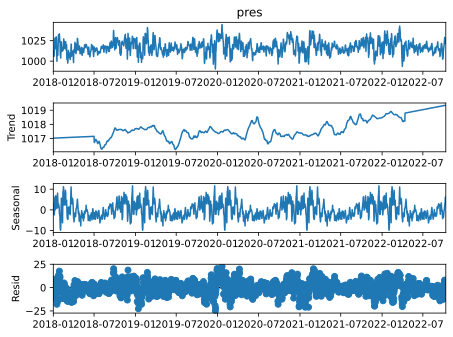

In [21]:
seasonal_decompose(df["pres"], model="additive", period=365, extrapolate_trend="freq").plot()
plt.show()

Let's populate the new dataframe with the decomposed series:

In [22]:
# Get old columns
original_cols = df.columns

# Iterate every column feature
for col in num_features:
    
    # perform the decomposition
    decomposed = seasonal_decompose(df[col], model="additive", period=365, extrapolate_trend="freq")
    
    # Create the trend, seasonal and remainder columns for each feature
    df[f"{col}_t"] = decomposed.trend
    df[f"{col}_s"] = decomposed.seasonal
    df[f"{col}_r"] = decomposed.resid
    
df

,tavg,tmin,tmax,wdir,wspd,pres,day,week,month,year,...,tmax_r,wdir_t,wdir_s,wdir_r,wspd_t,wspd_s,wspd_r,pres_t,pres_s,pres_r
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3.1,0.6,5.4,48.0,6.5,1011.7,1,1,1,2018,...,-2.673264,162.989534,39.801348,-154.790882,7.994651,-1.282647,-0.212004,1017.023757,3.011254,-8.335010
2018-01-02,5.0,2.3,7.7,335.0,11.4,1009.5,2,1,1,2018,...,-0.370716,163.066633,67.997983,103.935384,7.996125,3.768236,-0.364361,1017.024462,1.450017,-8.974479
2018-01-03,4.0,0.7,6.6,223.0,12.2,1007.9,3,1,1,2018,...,0.732929,163.143732,1.956262,57.900006,7.997598,2.227339,1.975063,1017.025168,2.968506,-12.093673
2018-01-04,4.7,2.2,10.4,190.0,8.0,1005.8,4,1,1,2018,...,2.255915,163.220831,34.086048,-7.306879,7.999071,2.263976,-2.263047,1017.025873,0.066885,-11.292758
2018-01-05,6.4,3.7,9.5,144.0,6.3,1007.3,5,1,1,2018,...,1.936929,163.297930,-4.365536,-14.932394,8.000545,3.358147,-5.058691,1017.026579,-2.435064,-7.291515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-07,15.6,11.0,21.4,69.0,6.5,1028.0,7,40,10,2022,...,2.782035,208.836425,-87.471591,-52.364834,10.353775,-2.539677,-1.314098,1019.343495,3.047690,5.608815
2022-10-08,14.6,9.7,20.0,59.0,5.1,1021.7,8,40,10,2022,...,-0.044880,208.793926,-79.332681,-70.461245,10.355378,-0.363121,-4.892257,1019.346579,3.593100,-1.239679
2022-10-09,15.4,11.4,19.6,6.0,8.2,1023.5,9,40,10,2022,...,0.210179,208.751426,-67.595414,-135.156013,10.356982,-1.829962,-0.327019,1019.349662,5.896867,-1.746529


Let's check how strong the trend and seasonal component are for each time-series in our data. We will use the following equations:
$$ F_T = \max \left( 0, 1 - \frac{\text{Var} \left( R_t \right) }{ \text{Var} \left( R_t + T_t \right) } \right) $$
$$ F_S = \max \left( 0, 1 - \frac{\text{Var} \left( R_t \right) }{ \text{Var} \left( R_t + S_t \right) } \right) $$

$F_T$ measures the strength of the trendend component: $F_T \approx 0$ for weak trend and $F_T \approx 1$ for strong trend.

$F_S$ measures the strength of the trendend component: $F_S \approx 0$ for weak seasonality and $F_S \approx 1$ for strong seasonality.

In [23]:
# Iterate every numeric column
results = {"time-series": [], "trend-strength": [], "seasonal-strength": []}
for col in num_features:
    
    # Calculate strength of trended component
    r_var = df[col + "_r"].var()
    rt_var = (df[col + "_t"] + df[col + "_r"]).var()
    t_str = max(0, 1 - r_var / rt_var)
    
    # Calculate strength of seasonal component
    rs_var = (df[col + "_s"] + df[col + "_r"]).var()
    s_str = max(0, 1 - r_var / rs_var)
    
    results["time-series"].append(col)
    results["trend-strength"].append(t_str)
    results["seasonal-strength"].append(s_str)
    
results = pd.DataFrame(results)
results

,time-series,trend-strength,seasonal-strength
0,tavg,0.013732,0.874796
1,tmin,0.019743,0.852589
2,tmax,0.016732,0.851986
3,wdir,0.042994,0.203560
4,wspd,0.039931,0.245039
5,pres,0.003041,0.252609


From this analysis, we can easily see that the trended component is weak in every time-series, while the seasonal component is strong for every temperature time-series. This is another indicator that only the temperature features are likely to yield good forecasts.

## Autocorrelation functions

Many times our time series past (or lagged) points are highly correlated to future datapoints. If one compares the present signal $y_t$ to the one-lagged signal $y_{t-1}$, we can get their correlation. One can follow this procedure for many lagged versions $y_{t-k}$ of the original signal to obtain the Autocorrelation function, or ACF:

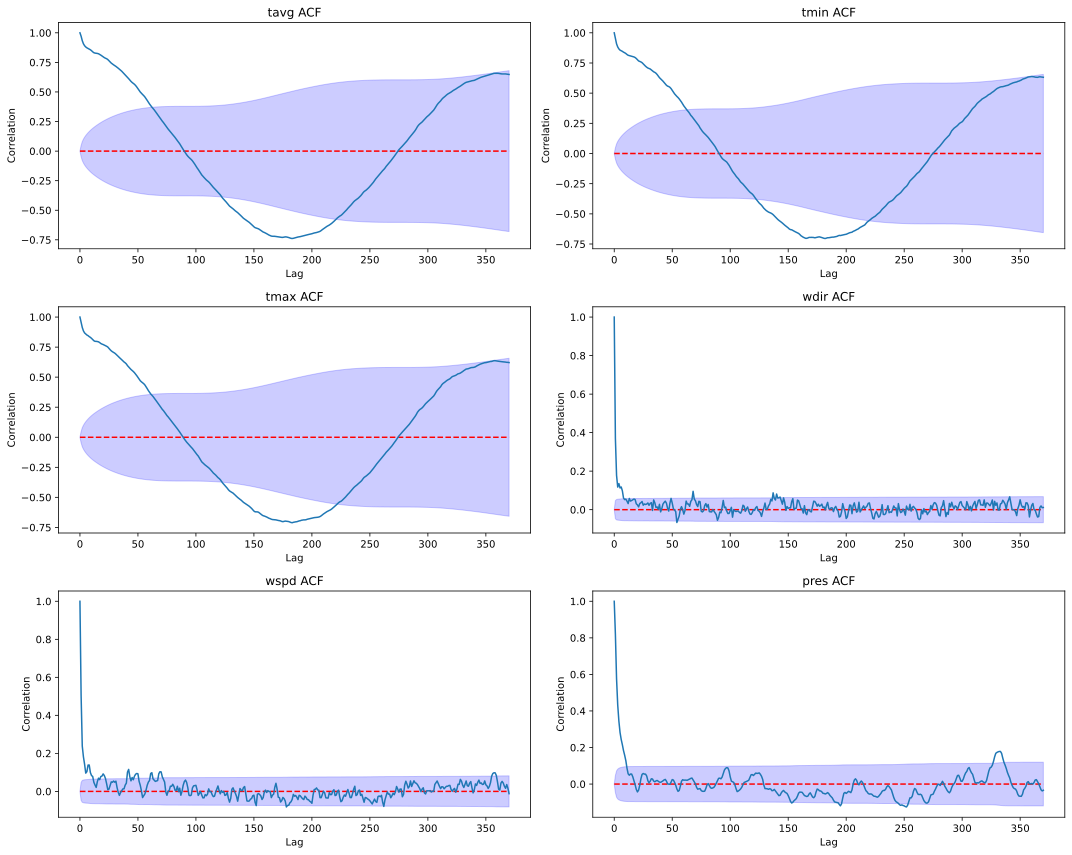

In [24]:
# Define number of lags
nlags = 370

# Create subfigure
fig, axs = plt.subplots(rows, cols, figsize=(15, 12))

# Iterate numeric columns
for k, col in enumerate(num_features):
    
    # Get axis to plot on
    i, j = k // cols, k % cols
    ax = axs[i,j]
    
    # Configure axis
    ax.set_title(f"{col} ACF")
    ax.set_xlabel("Lag")
    ax.set_ylabel(f"Correlation")
    
    # Calculate autocorrelation coefficients and confidence bounds
    acf_coeffs, conf = acf(df[col].values, alpha=0.05, nlags=nlags)
    x = range(len(acf_coeffs))
    
    # Make acf plot
    if nlags < 100:
        ax.stem(x, acf_coeffs)
    else:
        ax.plot(x, np.zeros(nlags+1), "--", color="red")
        ax.plot(x, acf_coeffs)
    ax.fill_between(x=x, y1=acf_coeffs-conf[:,0], y2=acf_coeffs-conf[:,1], alpha=0.2, color="blue")
    
plt.tight_layout()
plt.show()

As we can see from the ACF above, the temperature time-series autocorrelation seems almost cosine-like. This is because there is a very high periodicity in our signal, as we already saw. The temperature now is therefore highly correlated to the temperature 1 year prior, and naturally also highly correlated to the temperature in the last days.

## Conclusions

For data-processing, the only steps we needed to apply were:
- Linear interpolation for dealing with Missing Values
- Classical time-series decomposition using `statsmodels`

From analysing and visualizing the data, we drew the following conclusions:

- Selected Budapest as the target city for our forecasts
- Temperature time-series have a very strong seasonality
- Wind and pressure time-series have very weak seasonality
- All time-series have a very weak trend-cycle component
- Temperature seems like a very forecastable time-series
- Wind and pressure seem hardly forecastable, almost noise-like signals